In [1]:
%matplotlib inline

In [2]:
from collections import defaultdict
from itertools import product

import Orange
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import rankdata
from sklearn.cluster import AgglomerativeClustering

from sbm_neighbour_score import sbm_neighbour_score
from utils import SBM_Data, calc_avranks

In [3]:
data_hub = SBM_Data()
results, results_modularity_any3, modularity_results = data_hub.load_precalculated()

# Analyze results of SBM – Stochastic Block Model

In [4]:
# table for modularity any3
results_m3_dka = defaultdict(lambda: defaultdict(list)) # {dataset, {kernel_name: [best_ari_for_graph]}}
for (dataset, kernel_name, graph_idx), si_ari in results.items():
    results_m3_dka[dataset][kernel_name].append(si_ari['modularity_any3'])
for dataset, kernel_name in product(data_hub.datasets, data_hub.kernel_names):  # {dataset, {kernel_name: mean_bestari}}
    results_m3_dka[dataset][kernel_name] = np.mean(results_m3_dka[dataset][kernel_name])

dataset_meanari = {k: np.mean(list(v.values())) for k, v in results_m3_dka.items()}  # {dataset, mean_mean_bestari}
for dataset, meanari in sorted(list(dataset_meanari.items()), key=lambda x: x[1]):
    print(f'{dataset}: {meanari:.2f}')

200_4_0.10_0.100: 0.03
150_3_0.10_0.100: 0.04
100_4_0.10_0.100: 0.04
100_2_0.05_0.050: 0.04
102_3_0.10_0.100: 0.05
150_2_0.10_0.100: 0.05
100_2_0.15_0.150: 0.05
100_2_0.10_0.100: 0.05
100_2_0.10_0.100_1.00: 0.06
100_4_0.10_0.050: 0.08
200_4_0.10_0.050: 0.09
100_2_0.05_0.030: 0.10
100_2_0.10_0.070: 0.10
102_3_0.10_0.050: 0.12
150_3_0.10_0.050: 0.12
100_2_0.20_0.150: 0.13
100_2_0.10_0.050_1.00: 0.15
100_2_0.15_0.100: 0.15
100_2_0.05_0.020: 0.16
100_2_0.10_0.050: 0.22
100_4_0.30_0.150: 0.22
102_3_0.10_0.030: 0.26
100_4_0.10_0.020: 0.28
150_2_0.10_0.050: 0.32
200_4_0.30_0.150: 0.36
102_3_0.30_0.150: 0.38
100_2_0.15_0.070: 0.40
102_3_0.10_0.020: 0.45
100_2_0.05_0.010: 0.45
100_4_0.30_0.100: 0.52
100_2_0.20_0.100: 0.53
200_4_0.10_0.020: 0.55
100_4_0.10_0.010: 0.55
100_2_0.10_0.020_1.00: 0.58
100_2_0.05_0.007: 0.59
100_2_0.10_0.030: 0.59
150_3_0.10_0.020: 0.64
100_2_0.05_0.005: 0.72
100_4_0.10_0.005: 0.74
100_2_0.15_0.050: 0.74
150_2_0.10_0.030: 0.75
102_3_0.10_0.010: 0.75
500_2_0.10_0.050: 0

In [5]:
df = pd.DataFrame({k: {'ari': v} for k, v in dataset_meanari.items()}).transpose()
df['column'] = df.index.str.split('_').tolist()
df['n'] = df['column'].apply(lambda x: int(x[0]))
df['k'] = df['column'].apply(lambda x: int(x[1]))
df['p_in'] = df['column'].apply(lambda x: float(x[2]))
df['p_out'] = df['column'].apply(lambda x: float(x[3]))
df['p_in/p_out'] = df[['p_in', 'p_out']].apply(lambda x: x['p_in']/x['p_out'], axis=1)
df

,ari,column,n,k,p_in,p_out,p_in/p_out
100_2_0.05_0.001,0.943365,"[100, 2, 0.05, 0.001]",100,2,0.05,0.001,50.000000
100_2_0.05_0.002,0.902240,"[100, 2, 0.05, 0.002]",100,2,0.05,0.002,25.000000
100_2_0.05_0.005,0.717464,"[100, 2, 0.05, 0.005]",100,2,0.05,0.005,10.000000
100_2_0.05_0.007,0.585785,"[100, 2, 0.05, 0.007]",100,2,0.05,0.007,7.142857
100_2_0.05_0.010,0.448016,"[100, 2, 0.05, 0.010]",100,2,0.05,0.010,5.000000
100_2_0.05_0.020,0.157519,"[100, 2, 0.05, 0.020]",100,2,0.05,0.020,2.500000
100_2_0.05_0.030,0.097034,"[100, 2, 0.05, 0.030]",100,2,0.05,0.030,1.666667
100_2_0.05_0.050,0.041954,"[100, 2, 0.05, 0.050]",100,2,0.05,0.050,1.000000
100_2_0.10_0.001,0.994389,"[100, 2, 0.10, 0.001]",100,2,0.10,0.001,100.000000
100_2_0.10_0.002,0.991592,"[100, 2, 0.10, 0.002]",100,2,0.10,0.002,50.000000


In [6]:
dataset_modularity = dict()
for dataset in data_hub.datasets:
    dataset_modularity[dataset] = np.mean([modularity_results[(dataset, graph_idx)] for graph_idx in range(100)])
for dataset, modularity in sorted(list(dataset_modularity.items()), key=lambda x: x[1]):
    print(f'{dataset}: {modularity:.2f}')

100_4_0.10_0.100: -0.01
102_3_0.10_0.100: -0.01
100_2_0.05_0.050: -0.01
150_3_0.10_0.100: -0.01
100_2_0.15_0.150: -0.01
100_2_0.10_0.100: -0.01
200_4_0.10_0.100: -0.00
100_2_0.10_0.100_1.00: -0.00
150_2_0.10_0.100: -0.00
100_2_0.20_0.150: 0.07
100_2_0.10_0.070: 0.09
100_2_0.10_0.050_1.00: 0.09
100_2_0.15_0.100: 0.09
100_2_0.05_0.030: 0.12
100_4_0.10_0.050: 0.14
100_4_0.30_0.150: 0.14
200_4_0.30_0.150: 0.14
200_4_0.10_0.050: 0.14
102_3_0.10_0.050: 0.16
100_2_0.10_0.020_1.00: 0.16
150_3_0.10_0.050: 0.16
102_3_0.30_0.150: 0.16
100_2_0.20_0.100: 0.16
100_2_0.30_0.150: 0.16
100_2_0.10_0.050: 0.16
150_2_0.10_0.050: 0.16
200_2_0.30_0.150: 0.16
500_2_0.10_0.050: 0.17
100_2_0.15_0.070: 0.17
100_2_0.10_0.010_1.00: 0.19
100_2_0.10_0.005_1.00: 0.21
100_2_0.05_0.020: 0.21
100_2_0.10_0.001_1.00: 0.22
100_4_0.30_0.100: 0.24
200_4_0.30_0.100: 0.25
100_2_0.30_0.100: 0.25
100_2_0.15_0.050: 0.25
200_2_0.30_0.100: 0.25
102_3_0.30_0.100: 0.26
201_3_0.30_0.100: 0.26
150_2_0.10_0.030: 0.27
100_2_0.10_0.030: 

## CD diagram

n_experiments: 215000


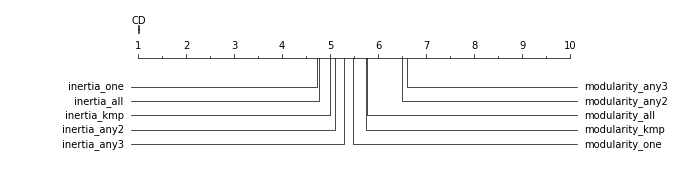

In [7]:
avranks, names, n_experiments = calc_avranks(results)
print(f'n_experiments: {n_experiments}')
cd = Orange.evaluation.compute_CD(avranks, n_experiments)
Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=9, textspace=1.5)
plt.show()

n_experiments: 8600


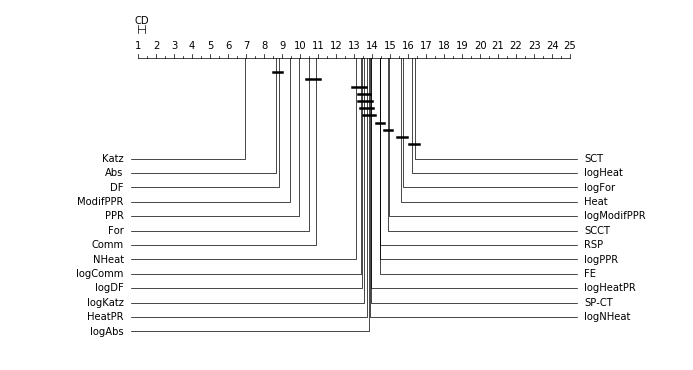

In [8]:
results_modularity_any3_flatter = defaultdict(lambda: defaultdict(list))
for (dataset, kernel_name, graph_idx), si_ari in results.items():
    results_modularity_any3_flatter[(dataset, graph_idx)][kernel_name] = si_ari['modularity_any3']

avranks, names, n_experiments = calc_avranks(results_modularity_any3_flatter)
print(f'n_experiments: {n_experiments}')
cd = Orange.evaluation.compute_CD(avranks, n_experiments, alpha='0.1')
Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=9, textspace=1.5)
plt.show()

## Group datasets by measure ranking

In [9]:
dataset_avranks = dict()  # {dataset: avranks}
for dataset_name, dataset_results in results_modularity_any3.items():
    avranks, _, _ = calc_avranks(dataset_results)
    dataset_avranks[dataset_name] = avranks

n_clusters = 4
# kmeans = KMeans(n_clusters=n_clusters)
kmeans = AgglomerativeClustering(linkage='ward', n_clusters=n_clusters)
kmeans.fit(list(dataset_avranks.values()))

datasets_partition = []  # [[dataset]]
for class_idx in range(n_clusters):
    datasetss = [dataset_name for dataset_name, label in zip(list(dataset_avranks.keys()), kmeans.labels_) if label == class_idx]
    datasets_partition.append(datasetss)
    
datasets_partition_mari = []
for partition in datasets_partition:
    datasets_partition_mari.append(np.mean([dataset_meanari[dataset] for dataset in partition]))

partition_order = [int(x)-1 for x in rankdata(datasets_partition_mari)]
datasets_partition = [datasets_partition[x] for x in partition_order]
datasets_partition_mari = [datasets_partition_mari[x] for x in partition_order]

data_hub.datasets_partition = datasets_partition

for i in range(n_clusters):
    print(f'Partition {i}, mari={datasets_partition_mari[i]:.2f}')
    print(f'  {", ".join(["(" + ", ".join(x.split("_")) + ")" for x in datasets_partition[i]])}')

Partition 0, mari=0.54
  (100, 2, 0.15, 0.070), (100, 2, 0.20, 0.100), (100, 2, 0.30, 0.150), (102, 3, 0.10, 0.020), (102, 3, 0.10, 0.030), (102, 3, 0.30, 0.100), (102, 3, 0.30, 0.150), (100, 4, 0.10, 0.010), (100, 4, 0.10, 0.020), (100, 4, 0.30, 0.100), (150, 2, 0.10, 0.050), (150, 3, 0.10, 0.020), (200, 4, 0.10, 0.010), (200, 4, 0.10, 0.020), (200, 4, 0.30, 0.100), (200, 4, 0.30, 0.150), (500, 2, 0.10, 0.050)
Partition 1, mari=0.12
  (100, 2, 0.05, 0.020), (100, 2, 0.05, 0.030), (100, 2, 0.05, 0.050), (100, 2, 0.10, 0.050), (100, 2, 0.10, 0.070), (100, 2, 0.10, 0.100), (100, 2, 0.10, 0.020, 1.00), (100, 2, 0.10, 0.050, 1.00), (100, 2, 0.10, 0.100, 1.00), (100, 2, 0.15, 0.100), (100, 2, 0.15, 0.150), (100, 2, 0.20, 0.150), (102, 3, 0.10, 0.050), (102, 3, 0.10, 0.100), (100, 4, 0.10, 0.050), (100, 4, 0.10, 0.100), (100, 4, 0.30, 0.150), (150, 2, 0.10, 0.100), (150, 3, 0.10, 0.050), (150, 3, 0.10, 0.100), (200, 4, 0.10, 0.050), (200, 4, 0.10, 0.100)
Partition 2, mari=0.93
  (100, 2, 0.0

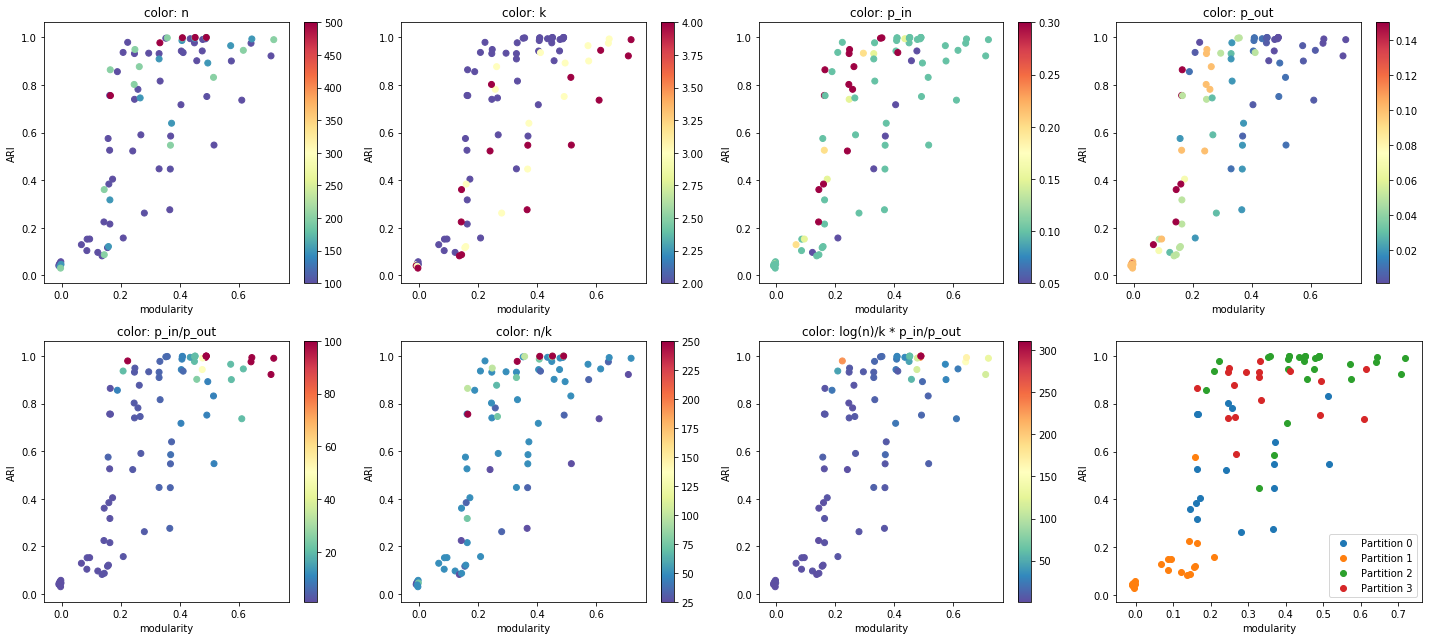

In [10]:
# draw ari-modularity dependency
fig, ax = plt.subplots(2, 4, figsize=(20, 9))
ax = np.ravel(ax)

for idx, feature in enumerate(['n', 'k', 'p_in', 'p_out', 'p_in/p_out', 'n/k', 'log(n)/k * p_in/p_out']):
    x, y, v = [], [], []
    for dataset in data_hub.datasets:
        x.append(dataset_modularity[dataset])
        y.append(dataset_meanari[dataset])
        v.append(data_hub.extract_feature(dataset, feature))
    sc = ax[idx].scatter(x, y, c=v, cmap='Spectral_r')
    ax[idx].set_xlabel('modularity')
    ax[idx].set_ylabel('ARI')
    ax[idx].set_title('color: ' + feature)
    plt.colorbar(sc, ax=ax[idx])
    
idx = 7
for class_idx in range(n_clusters):
    datasetss = datasets_partition[class_idx]
    x, y = [], []
    for dataset in datasetss:
        x.append(dataset_modularity[dataset])
        y.append(dataset_meanari[dataset])
    ax[idx].scatter(x, y, label=f'Partition {class_idx}')
ax[idx].set_xlabel('modularity')
ax[idx].set_ylabel('ARI')
ax[idx].legend(loc=4)

plt.tight_layout()

In [11]:
datasets_by_groups = defaultdict(dict)
for dataset in data_hub.datasets:
    if len(dataset.split('_')) == 4:
        n, k, p_in, p_out = [float(x) for x in dataset.split('_')]
        balance = 0
    else:
        n, k, p_in, p_out, balance = [float(x) for x in dataset.split('_')]
    
    n, k, p_in, p_out = int(n), int(k), float(p_in), float(p_out)
    n_normalized = n // 10 * 10
    
    group = '_'.join([str(x) for x in (n, k, balance, p_in, 'any')])
    datasets_by_groups[group][(n_normalized, k, balance, p_in, p_out)] = dataset

for group, datasetss in datasets_by_groups.items():
    print(f'{group}: {datasetss}')

100_2_0_0.05_any: {(100, 2, 0, 0.05, 0.001): '100_2_0.05_0.001', (100, 2, 0, 0.05, 0.002): '100_2_0.05_0.002', (100, 2, 0, 0.05, 0.005): '100_2_0.05_0.005', (100, 2, 0, 0.05, 0.007): '100_2_0.05_0.007', (100, 2, 0, 0.05, 0.01): '100_2_0.05_0.010', (100, 2, 0, 0.05, 0.02): '100_2_0.05_0.020', (100, 2, 0, 0.05, 0.03): '100_2_0.05_0.030', (100, 2, 0, 0.05, 0.05): '100_2_0.05_0.050'}
100_2_0_0.1_any: {(100, 2, 0, 0.1, 0.001): '100_2_0.10_0.001', (100, 2, 0, 0.1, 0.002): '100_2_0.10_0.002', (100, 2, 0, 0.1, 0.005): '100_2_0.10_0.005', (100, 2, 0, 0.1, 0.01): '100_2_0.10_0.010', (100, 2, 0, 0.1, 0.02): '100_2_0.10_0.020', (100, 2, 0, 0.1, 0.03): '100_2_0.10_0.030', (100, 2, 0, 0.1, 0.05): '100_2_0.10_0.050', (100, 2, 0, 0.1, 0.07): '100_2_0.10_0.070', (100, 2, 0, 0.1, 0.1): '100_2_0.10_0.100'}
100_2_1.0_0.1_any: {(100, 2, 1.0, 0.1, 0.001): '100_2_0.10_0.001_1.00', (100, 2, 1.0, 0.1, 0.005): '100_2_0.10_0.005_1.00', (100, 2, 1.0, 0.1, 0.01): '100_2_0.10_0.010_1.00', (100, 2, 1.0, 0.1, 0.02): 

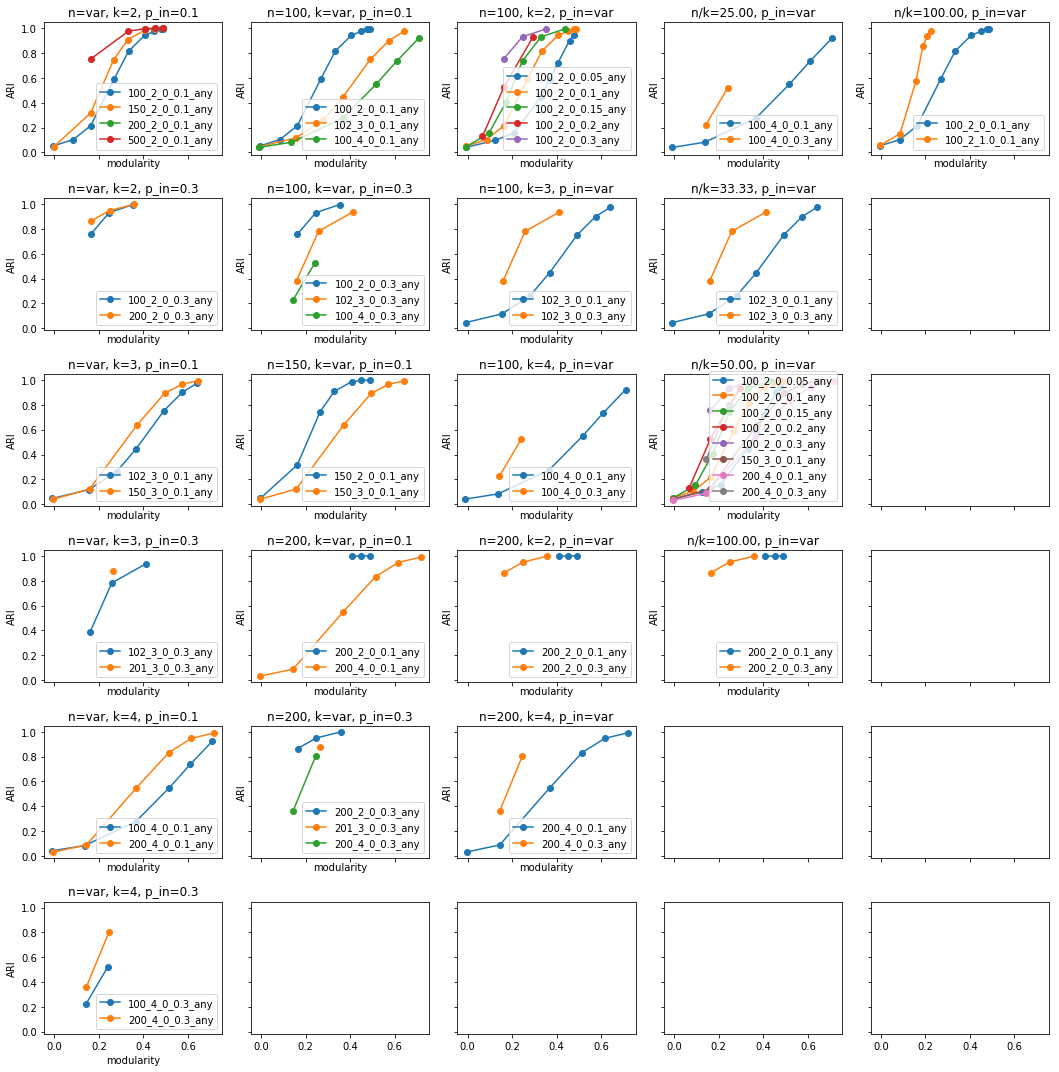

In [12]:
fig, ax = plt.subplots(6, 5, figsize=(15, 15), sharex=True, sharey=True)

# варьируем n при фиксированных k, p_in
idx = 0
for k, p_in in sorted(list(set([(int(group.split('_')[1]), float(group.split('_')[3])) for group, datasetss in datasets_by_groups.items()]))):
    datasets_to_plot = []
    for group, datasetss in datasets_by_groups.items():
        datasetss = [val for (dn, dk, dbalance, dp_in, _), val in sorted(datasetss.items(), key=lambda x: x[0], reverse=True)
                     if dk == k and dp_in == p_in and dbalance == 0]
        if len(datasetss) > 0:
            x, y = [], []
            for dataset in datasetss:
                x.append(dataset_modularity[dataset])
                y.append(dataset_meanari[dataset])
            datasets_to_plot.append((np.array(x), np.array(y), group))
            
    if len(datasets_to_plot) > 1:
        axi = ax[idx][0]
        for x, y, label in datasets_to_plot:
            axi.plot(x, y, '-o', label=label)
        axi.set_xlabel('modularity')
        axi.set_ylabel('ARI')
        axi.set_title(f'n=var, k={k}, p_in={p_in}')
        axi.legend(loc=4)
        idx += 1
    
# варьируем k при фиксированных n, p_in
idx = 0
for n, p_in in sorted(list(set([(int(group.split('_')[0]) // 10 * 10, float(group.split('_')[3])) for group, datasetss in datasets_by_groups.items()]))):
    datasets_to_plot = []
    for group, datasetss in datasets_by_groups.items():
        datasetss = [val for (dn, dk, dbalance, dp_in, _), val in sorted(datasetss.items(), key=lambda x: x[0], reverse=True)
                     if dn == n and dp_in == p_in and dbalance == 0]
        if len(datasetss) > 0:
            x, y = [], []
            for dataset in datasetss:
                x.append(dataset_modularity[dataset])
                y.append(dataset_meanari[dataset])
            datasets_to_plot.append((np.array(x), np.array(y), group))
            
    if len(datasets_to_plot) > 1:
        axi = ax[idx][1]
        for x, y, label in datasets_to_plot:
            axi.plot(x, y, '-o', label=label)
        axi.set_xlabel('modularity')
        axi.set_ylabel('ARI')
        axi.set_title(f'n={n}, k=var, p_in={p_in}')
        axi.legend(loc=4)
        idx += 1

# варьируем p_in при фиксированных n, k
idx = 0
for n, k in sorted(list(set([(int(group.split('_')[0]) // 10 * 10, int(group.split('_')[1])) for group, datasetss in datasets_by_groups.items()]))):
    datasets_to_plot = []
    for group, datasetss in datasets_by_groups.items():
        datasetss = [val for (dn, dk, dbalance, dp_in, _), val in sorted(datasetss.items(), key=lambda x: x[0], reverse=True)
                     if dn == n and dk == k and dbalance == 0]
        if len(datasetss) > 0:
            x, y = [], []
            for dataset in datasetss:
                x.append(dataset_modularity[dataset])
                y.append(dataset_meanari[dataset])
            datasets_to_plot.append((np.array(x), np.array(y), group))

    if len(datasets_to_plot) > 1:
        axi = ax[idx][2]
        for x, y, label in datasets_to_plot:
            axi.plot(x, y, '-o', label=label)
        axi.set_xlabel('modularity')
        axi.set_ylabel('ARI')
        axi.set_title(f'n={n}, k={k}, p_in=var')
        axi.legend(loc=4)
        idx += 1
        
# варьируем p_in при фиксированных n/k
idx = 0
for n_k in [100/4, 100/3, 100/2, 100.]:
    datasets_to_plot = []
    for group, datasetss in datasets_by_groups.items():
        datasetss = [val for (dn, dk, dbalance, dp_in, _), val in sorted(datasetss.items(), key=lambda x: x[0], reverse=True)
                     if dn/dk == n_k and dbalance == 0]
        if len(datasetss) > 0:
            x, y = [], []
            for dataset in datasetss:
                x.append(dataset_modularity[dataset])
                y.append(dataset_meanari[dataset])
            datasets_to_plot.append((np.array(x), np.array(y), group))

    if len(datasets_to_plot) > 1:
        axi = ax[idx][3]
        for x, y, label in datasets_to_plot:
            axi.plot(x, y, '-o', label=label)
        axi.set_xlabel('modularity')
        axi.set_ylabel('ARI')
        axi.set_title(f'n/k={n_k:.2f}, p_in=var')
        axi.legend(loc=4)
        idx += 1
        
# варьируем balance при фиксированных n, k, p_in
idx = 0
for n, k, p_in in [(100, 2, 0.1)]:
    datasets_to_plot = []
    for group, datasetss in datasets_by_groups.items():
        datasetss = [val for (dn, dk, dbalance, dp_in, _), val in sorted(datasetss.items(), key=lambda x: x[0], reverse=True)
                     if dn == n and dk == k and dp_in == p_in]
        if len(datasetss) > 0:
            x, y = [], []
            for dataset in datasetss:
                x.append(dataset_modularity[dataset])
                y.append(dataset_meanari[dataset])
            datasets_to_plot.append((np.array(x), np.array(y), group))

    if len(datasets_to_plot) > 1:
        axi = ax[idx][4]
        for x, y, label in datasets_to_plot:
            axi.plot(x, y, '-o', label=label)
        axi.set_xlabel('modularity')
        axi.set_ylabel('ARI')
        axi.set_title(f'n/k={n_k:.2f}, p_in=var')
        axi.legend(loc=4)
        idx += 1
        
plt.tight_layout()

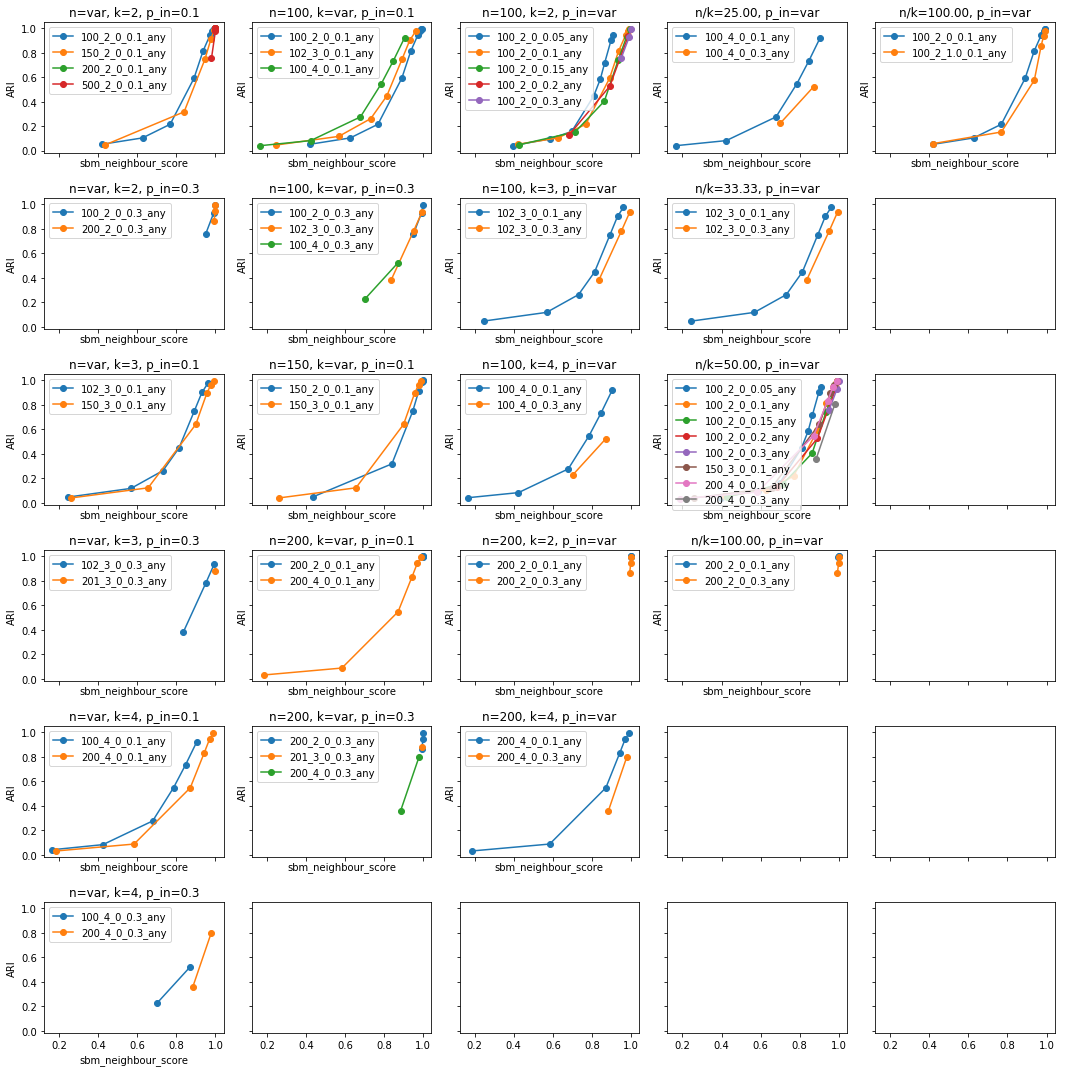

In [13]:
fig, ax = plt.subplots(6, 5, figsize=(15, 15), sharex=True, sharey=True)

# варьируем n при фиксированных k, p_in
idx = 0
for k, p_in in sorted(list(set([(int(group.split('_')[1]), float(group.split('_')[3])) for group, datasetss in datasets_by_groups.items()]))):
    datasets_to_plot = []
    for group, datasetss in datasets_by_groups.items():
        datasetss = [val for (dn, dk, dbalance, dp_in, _), val in sorted(datasetss.items(), key=lambda x: x[0], reverse=True)
                     if dk == k and dp_in == p_in and dbalance == 0]
        if len(datasetss) > 0:
            x, y = [], []
            for dataset in datasetss:
                x.append(data_hub.extract_feature(dataset, 'sbm_neighbour_score'))
                y.append(dataset_meanari[dataset])
            datasets_to_plot.append((np.array(x), np.array(y), group))
            
    if len(datasets_to_plot) > 1:
        axi = ax[idx][0]
        for x, y, label in datasets_to_plot:
            axi.plot(x, y, '-o', label=label)
        axi.set_xlabel('sbm_neighbour_score')
        axi.set_ylabel('ARI')
        axi.set_title(f'n=var, k={k}, p_in={p_in}')
        axi.legend(loc=2)
        idx += 1
    
    
# варьируем k при фиксированных n, p_in
idx = 0
for n, p_in in sorted(list(set([(int(group.split('_')[0]) // 10 * 10, float(group.split('_')[3])) for group, datasetss in datasets_by_groups.items()]))):
    datasets_to_plot = []
    for group, datasetss in datasets_by_groups.items():
        datasetss = [val for (dn, dk, dbalance, dp_in, _), val in sorted(datasetss.items(), key=lambda x: x[0], reverse=True) 
                     if dn == n and dp_in == p_in and dbalance == 0]
        if len(datasetss) > 0:
            x, y = [], []
            for dataset in datasetss:
                x.append(data_hub.extract_feature(dataset, 'sbm_neighbour_score'))
                y.append(dataset_meanari[dataset])
            datasets_to_plot.append((np.array(x), np.array(y), group))
            
    if len(datasets_to_plot) > 1:
        axi = ax[idx][1]
        for x, y, label in datasets_to_plot:
            axi.plot(x, y, '-o', label=label)
        axi.set_xlabel('sbm_neighbour_score')
        axi.set_ylabel('ARI')
        axi.set_title(f'n={n}, k=var, p_in={p_in}')
        axi.legend(loc=2)
        idx += 1

# варьируем p_in при фиксированных n, k
idx = 0
for n, k in sorted(list(set([(int(group.split('_')[0]) // 10 * 10, int(group.split('_')[1])) for group, datasetss in datasets_by_groups.items()]))):
    datasets_to_plot = []
    for group, datasetss in datasets_by_groups.items():
        datasetss = [val for (dn, dk, dbalance, dp_in, _), val in sorted(datasetss.items(), key=lambda x: x[0], reverse=True) 
                     if dn == n and dk == k and dbalance == 0]
        if len(datasetss) > 0:
            x, y = [], []
            for dataset in datasetss:
                x.append(data_hub.extract_feature(dataset, 'sbm_neighbour_score'))
                y.append(dataset_meanari[dataset])
            datasets_to_plot.append((np.array(x), np.array(y), group))
            
    if len(datasets_to_plot) > 1:
        axi = ax[idx][2]
        for x, y, label in datasets_to_plot:
            axi.plot(x, y, '-o', label=label)
        axi.set_xlabel('sbm_neighbour_score')
        axi.set_ylabel('ARI')
        axi.set_title(f'n={n}, k={k}, p_in=var')
        axi.legend(loc=2)
        idx += 1
        
# варьируем p_in при фиксированном n/k
idx = 0
for n_k in [100/4, 100/3, 100/2, 100.]:
    datasets_to_plot = []
    for group, datasetss in datasets_by_groups.items():
        datasetss = [val for (dn, dk, dbalance, dp_in, _), val in sorted(datasetss.items(), key=lambda x: x[0], reverse=True) 
                     if dn/dk == n_k and dbalance == 0]
        if len(datasetss) > 0:
            x, y = [], []
            for dataset in datasetss:
                x.append(data_hub.extract_feature(dataset, 'sbm_neighbour_score'))
                y.append(dataset_meanari[dataset])
            datasets_to_plot.append((np.array(x), np.array(y), group))
            
    if len(datasets_to_plot) > 1:
        axi = ax[idx][3]
        for x, y, label in datasets_to_plot:
            axi.plot(x, y, '-o', label=label)
        axi.set_xlabel('sbm_neighbour_score')
        axi.set_ylabel('ARI')
        axi.set_title(f'n/k={n_k:.2f}, p_in=var')
        axi.legend(loc=2)
        idx += 1
        
# варьируем balance при фиксированном n, k, p_in
idx = 0
for n, k, p_in in [(100, 2, 0.1)]:
    datasets_to_plot = []
    for group, datasetss in datasets_by_groups.items():
        datasetss = [val for (dn, dk, dbalance, dp_in, _), val in sorted(datasetss.items(), key=lambda x: x[0], reverse=True)
                     if dn == n and dk == k and dp_in == p_in]
        if len(datasetss) > 0:
            x, y = [], []
            for dataset in datasetss:
                x.append(data_hub.extract_feature(dataset, 'sbm_neighbour_score'))
                y.append(dataset_meanari[dataset])
            datasets_to_plot.append((np.array(x), np.array(y), group))
            
    if len(datasets_to_plot) > 1:
        axi = ax[idx][4]
        for x, y, label in datasets_to_plot:
            axi.plot(x, y, '-o', label=label)
        axi.set_xlabel('sbm_neighbour_score')
        axi.set_ylabel('ARI')
        axi.set_title(f'n/k={n_k:.2f}, p_in=var')
        axi.legend(loc=2)
        idx += 1
        
plt.tight_layout()

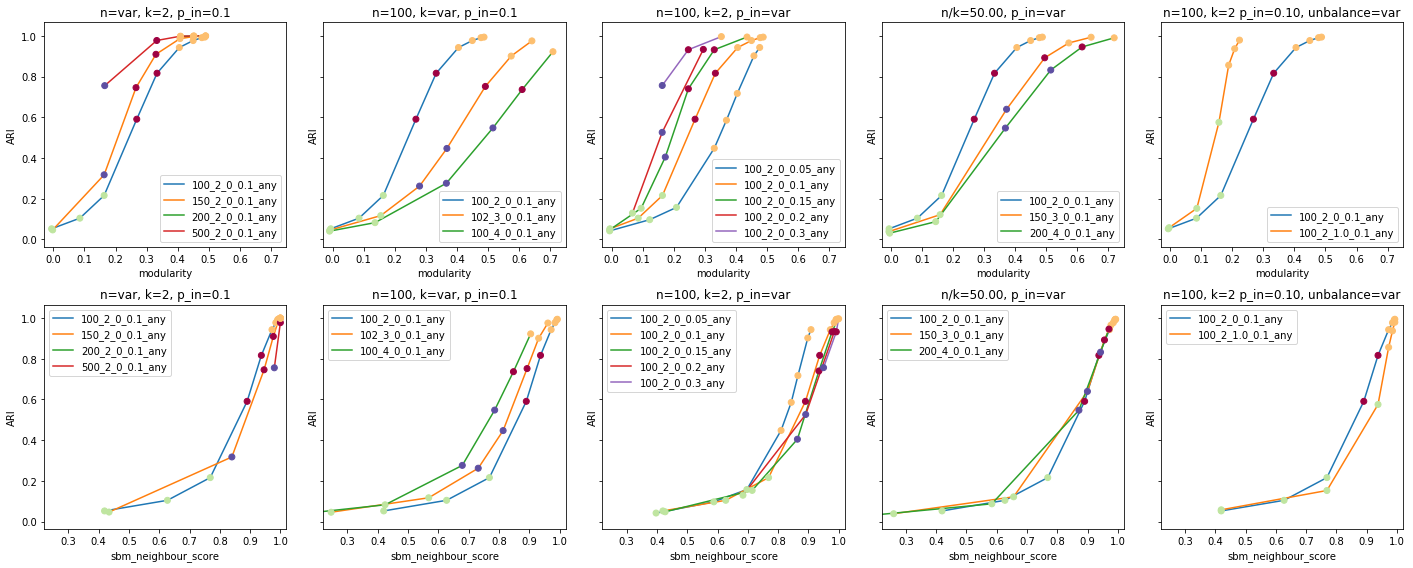

In [14]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8), sharey=True)

mod_xlim = -.03, .75
sns_xlim = 0.22, 1.02

# варьируем n при фиксированных k, p_in
k, p_in = 2, 0.1
datasets_to_plot = []
for group, datasetss in datasets_by_groups.items():
    datasetss = [val for (dn, dk, dbalance, dp_in, _), val in sorted(datasetss.items(), key=lambda x: x[0], reverse=True)
                 if dk == k and dp_in == p_in and dbalance == 0]
    if len(datasetss) > 0:
        mod, ari, sns, cls_ = [], [], [], []
        for dataset in datasetss:
            mod.append(dataset_modularity[dataset])
            sns.append(data_hub.extract_feature(dataset, 'sbm_neighbour_score'))
            ari.append(dataset_meanari[dataset])
            cls_.append(data_hub.extract_feature(dataset, 'class_idx'))
        datasets_to_plot.append((np.array(mod), np.array(sns), np.array(ari), np.array(cls_), group))

axi = ax[0][0]
for x, _, y, cls_, label in datasets_to_plot:
    axi.plot(x, y, '-', label=label, zorder=1)
    axi.scatter(x, y, c=cls_, cmap='Spectral_r', zorder=2, vmin=0, vmax=3)
axi.set_xlabel('modularity')
axi.set_ylabel('ARI')
axi.set_title(f'n=var, k={k}, p_in={p_in}')
axi.legend(loc=4)
axi.set_xlim(*mod_xlim)

axi = ax[1][0]
for _, x, y, cls_, label in datasets_to_plot:
    axi.plot(x, y, '-', label=label, zorder=1)
    axi.scatter(x, y, c=cls_, cmap='Spectral_r', zorder=2, vmin=0, vmax=3)
axi.set_xlabel('sbm_neighbour_score')
axi.set_ylabel('ARI')
axi.set_title(f'n=var, k={k}, p_in={p_in}')
axi.legend(loc=2)
axi.set_xlim(*sns_xlim)


# варьируем k при фиксированных n, p_in
n, p_in = 100, 0.1
datasets_to_plot = []
for group, datasetss in datasets_by_groups.items():
    datasetss = [val for (dn, dk, dbalance, dp_in, _), val in sorted(datasetss.items(), key=lambda x: x[0], reverse=True) 
                 if dn == n and dp_in == p_in and dbalance == 0]
    if len(datasetss) > 0:
        mod, ari, sns, cls_ = [], [], [], []
        for dataset in datasetss:
            mod.append(dataset_modularity[dataset])
            sns.append(data_hub.extract_feature(dataset, 'sbm_neighbour_score'))
            ari.append(dataset_meanari[dataset])
            cls_.append(data_hub.extract_feature(dataset, 'class_idx'))
        datasets_to_plot.append((np.array(mod), np.array(sns), np.array(ari), np.array(cls_), group))

axi = ax[0][1]
for x, _, y, cls_, label in datasets_to_plot:
    axi.plot(x, y, '-', label=label, zorder=1)
    axi.scatter(x, y, c=cls_, cmap='Spectral_r', zorder=2, vmin=0, vmax=3)
axi.set_xlabel('modularity')
axi.set_ylabel('ARI')
axi.set_title(f'n={n}, k=var, p_in={p_in}')
axi.legend(loc=4)
axi.set_xlim(*mod_xlim)

axi = ax[1][1]
for _, x, y, cls_, label in datasets_to_plot:
    axi.plot(x, y, '-', label=label, zorder=1)
    axi.scatter(x, y, c=cls_, cmap='Spectral_r', zorder=2, vmin=0, vmax=3)
axi.set_xlabel('sbm_neighbour_score')
axi.set_ylabel('ARI')
axi.set_title(f'n={n}, k=var, p_in={p_in}')
axi.legend(loc=2)
axi.set_xlim(*sns_xlim)


# варьируем p_in при фиксированных n, k
n, k = 100, 2
datasets_to_plot = []
for group, datasetss in datasets_by_groups.items():
    datasetss = [val for (dn, dk, dbalance, dp_in, _), val in sorted(datasetss.items(), key=lambda x: x[0], reverse=True)
                 if dn == n and dk == k and dbalance == 0]
    if len(datasetss) > 0:
        mod, ari, sns, cls_ = [], [], [], []
        for dataset in datasetss:
            mod.append(dataset_modularity[dataset])
            sns.append(data_hub.extract_feature(dataset, 'sbm_neighbour_score'))
            ari.append(dataset_meanari[dataset])
            cls_.append(data_hub.extract_feature(dataset, 'class_idx'))
        datasets_to_plot.append((np.array(mod), np.array(sns), np.array(ari), np.array(cls_), group))

axi = ax[0][2]
for x, _, y, cls_, label in datasets_to_plot:
    axi.plot(x, y, '-', label=label, zorder=1)
    axi.scatter(x, y, c=cls_, cmap='Spectral_r', zorder=2, vmin=0, vmax=3)
axi.set_xlabel('modularity')
axi.set_ylabel('ARI')
axi.set_title(f'n={n}, k={k}, p_in=var')
axi.legend(loc=4)
axi.set_xlim(*mod_xlim)

axi = ax[1][2]
for _, x, y, cls_, label in datasets_to_plot:
    axi.plot(x, y, '-', label=label, zorder=1)
    axi.scatter(x, y, c=cls_, cmap='Spectral_r', zorder=2, vmin=0, vmax=3)
axi.set_xlabel('sbm_neighbour_score')
axi.set_ylabel('ARI')
axi.set_title(f'n={n}, k={k}, p_in=var')
axi.legend(loc=2)
axi.set_xlim(*sns_xlim)


# варьируем p_in при фиксированных n/k
n_k, p_in = 100/2, 0.1
datasets_to_plot = []
for group, datasetss in datasets_by_groups.items():
    datasetss = [val for (dn, dk, dbalance, dp_in, _), val in sorted(datasetss.items(), key=lambda x: x[0], reverse=True)
                 if dn/dk == n_k and dp_in == p_in and dbalance == 0]
    if len(datasetss) > 0:
        mod, ari, sns, cls_ = [], [], [], []
        for dataset in datasetss:
            mod.append(dataset_modularity[dataset])
            sns.append(data_hub.extract_feature(dataset, 'sbm_neighbour_score'))
            ari.append(dataset_meanari[dataset])
            cls_.append(data_hub.extract_feature(dataset, 'class_idx'))
        datasets_to_plot.append((np.array(mod), np.array(sns), np.array(ari), np.array(cls_), group))

axi = ax[0][3]
for x, _, y, cls_, label in datasets_to_plot:
    axi.plot(x, y, '-', label=label, zorder=1)
    axi.scatter(x, y, c=cls_, cmap='Spectral_r', zorder=2, vmin=0, vmax=3)
axi.set_xlabel('modularity')
axi.set_ylabel('ARI')
axi.set_title(f'n/k={n_k:.2f}, p_in=var')
axi.legend(loc=4)
axi.set_xlim(*mod_xlim)

axi = ax[1][3]
for _, x, y, cls_, label in datasets_to_plot:
    axi.plot(x, y, '-', label=label, zorder=1)
    axi.scatter(x, y, c=cls_, cmap='Spectral_r', zorder=2, vmin=0, vmax=3)
axi.set_xlabel('sbm_neighbour_score')
axi.set_ylabel('ARI')
axi.set_title(f'n/k={n_k:.2f}, p_in=var')
axi.legend(loc=2)
axi.set_xlim(*sns_xlim)


# варьируем dbalance при фиксированных n, k, p_in
n, k, p_in = 100, 2, 0.1
datasets_to_plot = []
for group, datasetss in datasets_by_groups.items():
    datasetss = [val for (dn, dk, dbalance, dp_in, _), val in sorted(datasetss.items(), key=lambda x: x[0], reverse=True)
                 if dn == n and dk == k and dp_in == p_in]
    if len(datasetss) > 0:
        mod, ari, sns, cls_ = [], [], [], []
        for dataset in datasetss:
            mod.append(dataset_modularity[dataset])
            sns.append(data_hub.extract_feature(dataset, 'sbm_neighbour_score'))
            ari.append(dataset_meanari[dataset])
            cls_.append(data_hub.extract_feature(dataset, 'class_idx'))
        datasets_to_plot.append((np.array(mod), np.array(sns), np.array(ari), np.array(cls_), group))

axi = ax[0][4]
for x, _, y, cls_, label in datasets_to_plot:
    axi.plot(x, y, '-', label=label, zorder=1)
    axi.scatter(x, y, c=cls_, cmap='Spectral_r', zorder=2, vmin=0, vmax=3)
axi.set_xlabel('modularity')
axi.set_ylabel('ARI')
axi.set_title(f'n={n}, k={k} p_in={p_in:.2f}, unbalance=var')
axi.legend(loc=4)
axi.set_xlim(*mod_xlim)

axi = ax[1][4]
for _, x, y, cls_, label in datasets_to_plot:
    axi.plot(x, y, '-', label=label, zorder=1)
    axi.scatter(x, y, c=cls_, cmap='Spectral_r', zorder=2, vmin=0, vmax=3)
axi.set_xlabel('sbm_neighbour_score')
axi.set_ylabel('ARI')
axi.set_title(f'n={n}, k={k} p_in={p_in:.2f}, unbalance=var')
axi.legend(loc=2)
axi.set_xlim(*sns_xlim)


plt.tight_layout()

Partition 0, mari=0.54, n_experiments: 1700
  (100, 2, 0.15, 0.070), (100, 2, 0.20, 0.100), (100, 2, 0.30, 0.150), (102, 3, 0.10, 0.020), (102, 3, 0.10, 0.030), (102, 3, 0.30, 0.100), (102, 3, 0.30, 0.150), (100, 4, 0.10, 0.010), (100, 4, 0.10, 0.020), (100, 4, 0.30, 0.100), (150, 2, 0.10, 0.050), (150, 3, 0.10, 0.020), (200, 4, 0.10, 0.010), (200, 4, 0.10, 0.020), (200, 4, 0.30, 0.100), (200, 4, 0.30, 0.150), (500, 2, 0.10, 0.050)


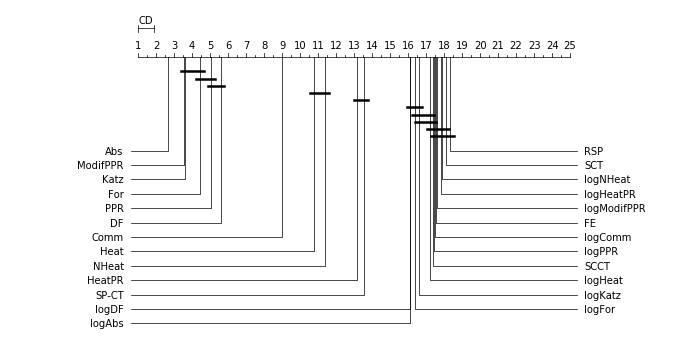

Partition 1, mari=0.12, n_experiments: 2200
  (100, 2, 0.05, 0.020), (100, 2, 0.05, 0.030), (100, 2, 0.05, 0.050), (100, 2, 0.10, 0.050), (100, 2, 0.10, 0.070), (100, 2, 0.10, 0.100), (100, 2, 0.10, 0.020, 1.00), (100, 2, 0.10, 0.050, 1.00), (100, 2, 0.10, 0.100, 1.00), (100, 2, 0.15, 0.100), (100, 2, 0.15, 0.150), (100, 2, 0.20, 0.150), (102, 3, 0.10, 0.050), (102, 3, 0.10, 0.100), (100, 4, 0.10, 0.050), (100, 4, 0.10, 0.100), (100, 4, 0.30, 0.150), (150, 2, 0.10, 0.100), (150, 3, 0.10, 0.050), (150, 3, 0.10, 0.100), (200, 4, 0.10, 0.050), (200, 4, 0.10, 0.100)


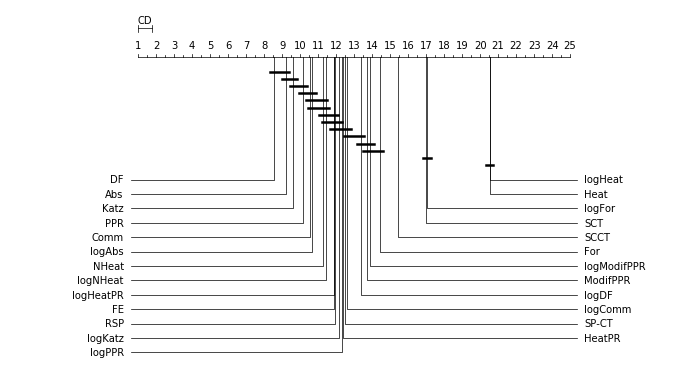

Partition 2, mari=0.93, n_experiments: 3000
  (100, 2, 0.05, 0.001), (100, 2, 0.05, 0.002), (100, 2, 0.05, 0.005), (100, 2, 0.05, 0.007), (100, 2, 0.05, 0.010), (100, 2, 0.10, 0.001), (100, 2, 0.10, 0.002), (100, 2, 0.10, 0.005), (100, 2, 0.10, 0.010), (100, 2, 0.10, 0.001, 1.00), (100, 2, 0.10, 0.005, 1.00), (100, 2, 0.10, 0.010, 1.00), (100, 2, 0.15, 0.010), (100, 2, 0.30, 0.050), (102, 3, 0.10, 0.001), (102, 3, 0.10, 0.005), (100, 4, 0.10, 0.001), (150, 2, 0.10, 0.001), (150, 2, 0.10, 0.005), (150, 2, 0.10, 0.010), (150, 3, 0.10, 0.001), (150, 3, 0.10, 0.005), (200, 2, 0.10, 0.001), (200, 2, 0.10, 0.005), (200, 2, 0.10, 0.010), (200, 2, 0.30, 0.050), (200, 4, 0.10, 0.001), (500, 2, 0.10, 0.001), (500, 2, 0.10, 0.005), (500, 2, 0.10, 0.010)


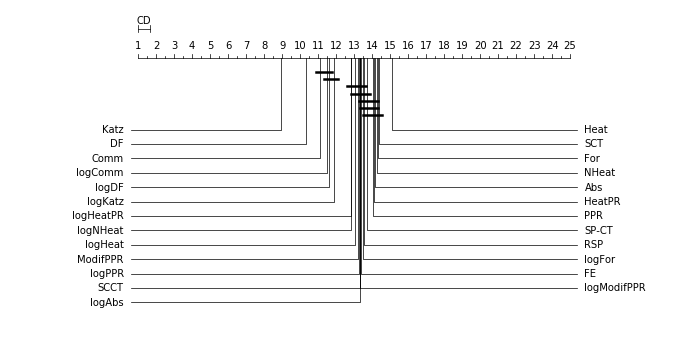

Partition 3, mari=0.85, n_experiments: 1700
  (100, 2, 0.10, 0.020), (100, 2, 0.10, 0.030), (100, 2, 0.15, 0.030), (100, 2, 0.15, 0.050), (100, 2, 0.20, 0.050), (100, 2, 0.30, 0.100), (102, 3, 0.10, 0.010), (102, 3, 0.30, 0.050), (100, 4, 0.10, 0.005), (150, 2, 0.10, 0.020), (150, 2, 0.10, 0.030), (150, 3, 0.10, 0.010), (200, 2, 0.30, 0.100), (200, 2, 0.30, 0.150), (201, 3, 0.30, 0.100), (200, 4, 0.10, 0.005), (500, 2, 0.10, 0.020)


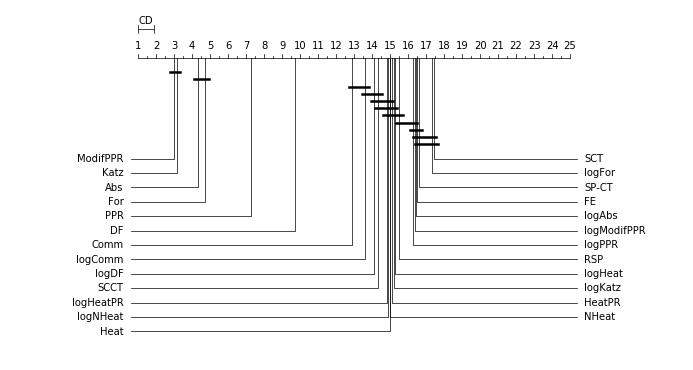

In [15]:
for group_idx, datasets_group in enumerate(datasets_partition):
    results_filtered = {k: v for k, v in results.items() if k[0] in datasets_group}
    results_modularity_any3 = defaultdict(lambda: defaultdict(list)) # {dataset_graphidx, {kernel_name: best_ari}}
    for (dataset, kernel_name, graph_idx), si_ari in results_filtered.items():
        results_modularity_any3[(dataset, graph_idx)][kernel_name] = si_ari['modularity_any3']

    avranks, names, n_experiments = calc_avranks(results_modularity_any3)
    
    print(f'Partition {group_idx}, mari={datasets_partition_mari[group_idx]:.2f}, n_experiments: {n_experiments}')
    print(f'  {", ".join(["(" + ", ".join(x.split("_")) + ")" for x in datasets_partition[group_idx]])}')
    cd = Orange.evaluation.compute_CD(avranks, n_experiments, alpha='0.1')
    Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=9, textspace=1.5)
    plt.show()

# SBM neighbour score

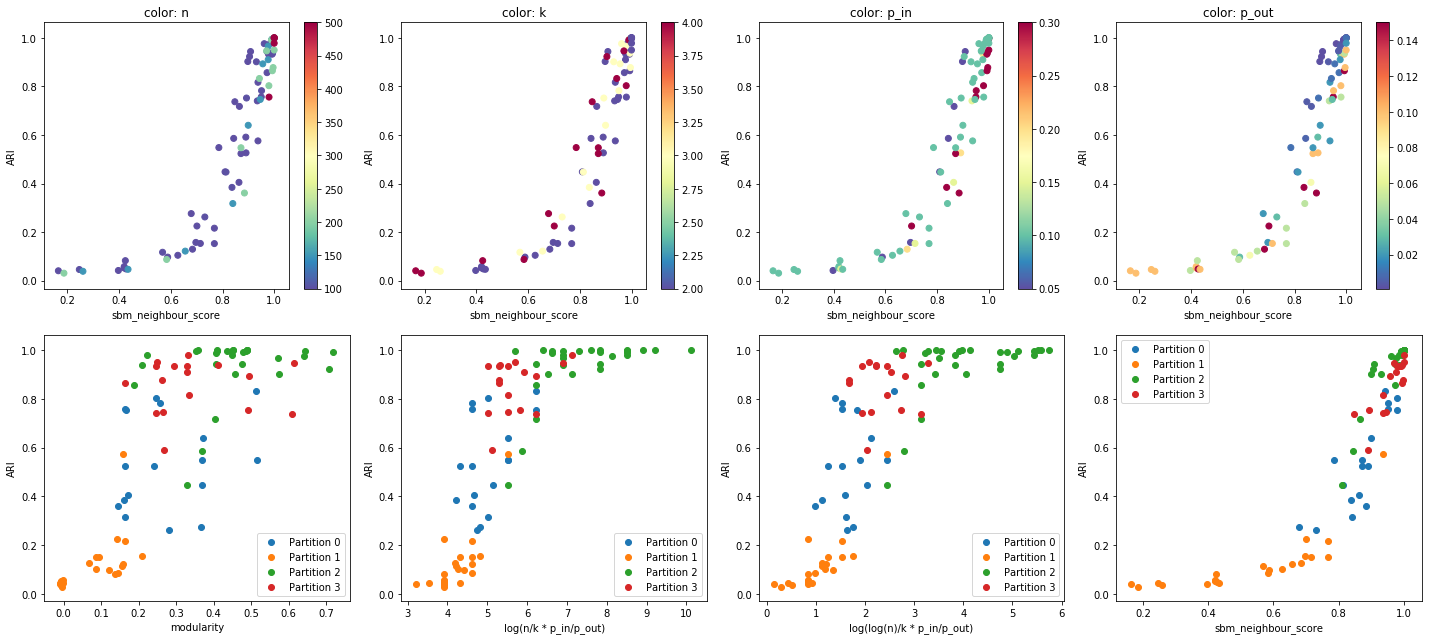

In [16]:
# draw ari-modularity dependency
fig, ax = plt.subplots(2, 4, figsize=(20, 9))
ax = np.ravel(ax)

for idx, feature in enumerate(['n', 'k', 'p_in', 'p_out']):
    x, y, v = [], [], []
    for dataset in data_hub.datasets:
        x.append(data_hub.extract_feature(dataset, 'sbm_neighbour_score'))
        y.append(dataset_meanari[dataset])
        v.append(data_hub.extract_feature(dataset, feature))
    sc = ax[idx].scatter(x, y, c=v, cmap='Spectral_r')
    ax[idx].set_xlabel('sbm_neighbour_score')
    ax[idx].set_ylabel('ARI')
    ax[idx].set_title('color: ' + feature)
    plt.colorbar(sc, ax=ax[idx])

idx = 4
for class_idx in range(n_clusters):
    datasetss = datasets_partition[class_idx]
    x, y = [], []
    for dataset in datasetss:
        x.append(dataset_modularity[dataset])
        y.append(dataset_meanari[dataset])
    sc = ax[idx].scatter(x, y, label=f'Partition {class_idx}')
ax[idx].set_xlabel('modularity')
ax[idx].set_ylabel('ARI')
ax[idx].legend(loc=4)

idx = 5
for class_idx in range(n_clusters):
    datasetss = datasets_partition[class_idx]
    x, y = [], []
    for dataset in datasetss:
        x.append(np.log(data_hub.extract_feature(dataset, 'n/k * p_in/p_out')))
        y.append(dataset_meanari[dataset])
    sc = ax[idx].scatter(x, y, label=f'Partition {class_idx}')
ax[idx].set_xlabel('log(n/k * p_in/p_out)')
ax[idx].set_ylabel('ARI')
ax[idx].legend(loc=4)

idx = 6
for class_idx in range(n_clusters):
    datasetss = datasets_partition[class_idx]
    x, y = [], []
    for dataset in datasetss:
        x.append(np.log(data_hub.extract_feature(dataset, 'log(n)/k * p_in/p_out')))
        y.append(dataset_meanari[dataset])
    sc = ax[idx].scatter(x, y, label=f'Partition {class_idx}')
ax[idx].set_xlabel('log(log(n)/k * p_in/p_out)')
ax[idx].set_ylabel('ARI')
ax[idx].legend(loc=4)

idx = 7
for class_idx in range(n_clusters):
    datasetss = datasets_partition[class_idx]
    x, y = [], []
    for dataset in datasetss:
        x.append(data_hub.extract_feature(dataset, 'sbm_neighbour_score'))
        y.append(dataset_meanari[dataset])
    ax[idx].scatter(x, y, label=f'Partition {class_idx}')
ax[idx].set_xlabel('sbm_neighbour_score')
ax[idx].set_ylabel('ARI')
ax[idx].legend(loc=2)

plt.tight_layout()

(array([2., 2., 0., 6., 3., 7., 2., 7., 5., 4., 5., 2., 6., 4., 3., 0., 7.,
        2., 2., 2., 3., 1., 0., 0., 3., 1., 2., 0., 3., 2.]),
 array([0.14088526, 0.32748661, 0.51408796, 0.70068931, 0.88729065,
        1.073892  , 1.26049335, 1.44709469, 1.63369604, 1.82029739,
        2.00689873, 2.19350008, 2.38010143, 2.56670277, 2.75330412,
        2.93990547, 3.12650681, 3.31310816, 3.49970951, 3.68631086,
        3.8729122 , 4.05951355, 4.2461149 , 4.43271624, 4.61931759,
        4.80591894, 4.99252028, 5.17912163, 5.36572298, 5.55232432,
        5.73892567]),
 <a list of 30 Patch objects>)

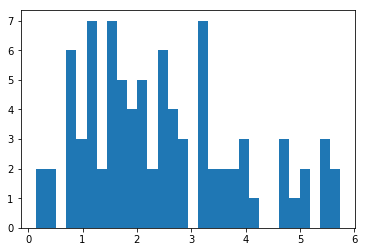

In [17]:
plt.hist([np.log(data_hub.extract_feature(dataset, 'log(n)/k * p_in/p_out')) for dataset in data_hub.datasets], bins=30)